### Firstly, we need to download datasets. ###

In [1]:
import pandas as pd
train = pd.read_csv('/Users/alexander/АДВБ/hse-dab-naf-23/my_train.csv', sep=',')
train

,period_dt,location_id,product_id,demand,PROMO1_FLAG,PROMO2_FLAG,NUM_CONSULTANT,AUTORIZATION_FLAG,id,ACTUAL_PRICE,location_zone_1,product_category_1
0,2016-12-19,504,37296,1.000000,0,0,0,0,258934,3328.855404,25,9912
1,2016-12-19,525,23165,1.000000,0,0,0,0,10099,3328.855404,54,9912
2,2016-12-19,1080,32411,0.350000,0,0,0,0,232092,3328.855404,189,3876
3,2016-12-19,1080,24002,1.000000,0,0,0,0,217478,3328.855404,189,9912
4,2016-12-19,657,37569,1.000000,0,0,0,0,54676,3328.855404,219,3876
...,...,...,...,...,...,...,...,...,...,...,...,...
271928,2019-12-02,1143,88983,0.491237,1,0,0,1,145956,1824.500000,39,9912
271929,2019-12-02,1034,88983,0.542515,1,0,0,1,145955,1824.500000,203,9912
271930,2019-12-02,798,88983,2.200000,1,0,0,1,145954,1824.500000,203,9912
271931,2019-12-02,1380,88983,1.000000,1,0,0,1,145964,2530.260000,219,9912


In [2]:
test = pd.read_csv('/Users/alexander/АДВБ/hse-dab-naf-23/my_test.csv', sep=',')
test

,period_dt,location_id,product_id,demand,PROMO1_FLAG,PROMO2_FLAG,NUM_CONSULTANT,AUTORIZATION_FLAG,id,ACTUAL_PRICE,location_zone_1,product_category_1
0,2019-12-30,1162,22939,NaN,0,0,0,1,16,3649.0,189,3876
1,2019-12-30,1162,23162,NaN,0,0,0,1,7867,3799.0,189,9912
2,2019-12-16,1162,23163,NaN,0,0,0,1,8667,3799.0,189,9912
3,2019-12-23,798,23632,NaN,0,0,0,1,14835,3999.0,203,9912
4,2019-12-30,1347,23633,NaN,0,0,0,1,14959,3999.0,189,9912
...,...,...,...,...,...,...,...,...,...,...,...,...
588,2019-12-16,1326,139157,NaN,1,0,0,1,203996,2449.5,203,9912
589,2019-12-09,1347,139157,NaN,0,0,0,0,203997,4899.0,189,9912
590,2019-12-09,425,148040,NaN,0,0,0,1,204035,3549.0,203,3885
591,2019-12-09,525,148040,NaN,0,0,0,1,204037,3549.0,54,3885


In [3]:
import datetime as dt
train['period_dt'] = pd.to_datetime(train['period_dt'])
test['period_dt'] = pd.to_datetime(test['period_dt'])
train['period_dt'] = train['period_dt'].apply(lambda x: x.date())
test['period_dt'] = test['period_dt'].apply(lambda x: x.date())

### Catboost regression without lag (window) features. ###

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 20, 10

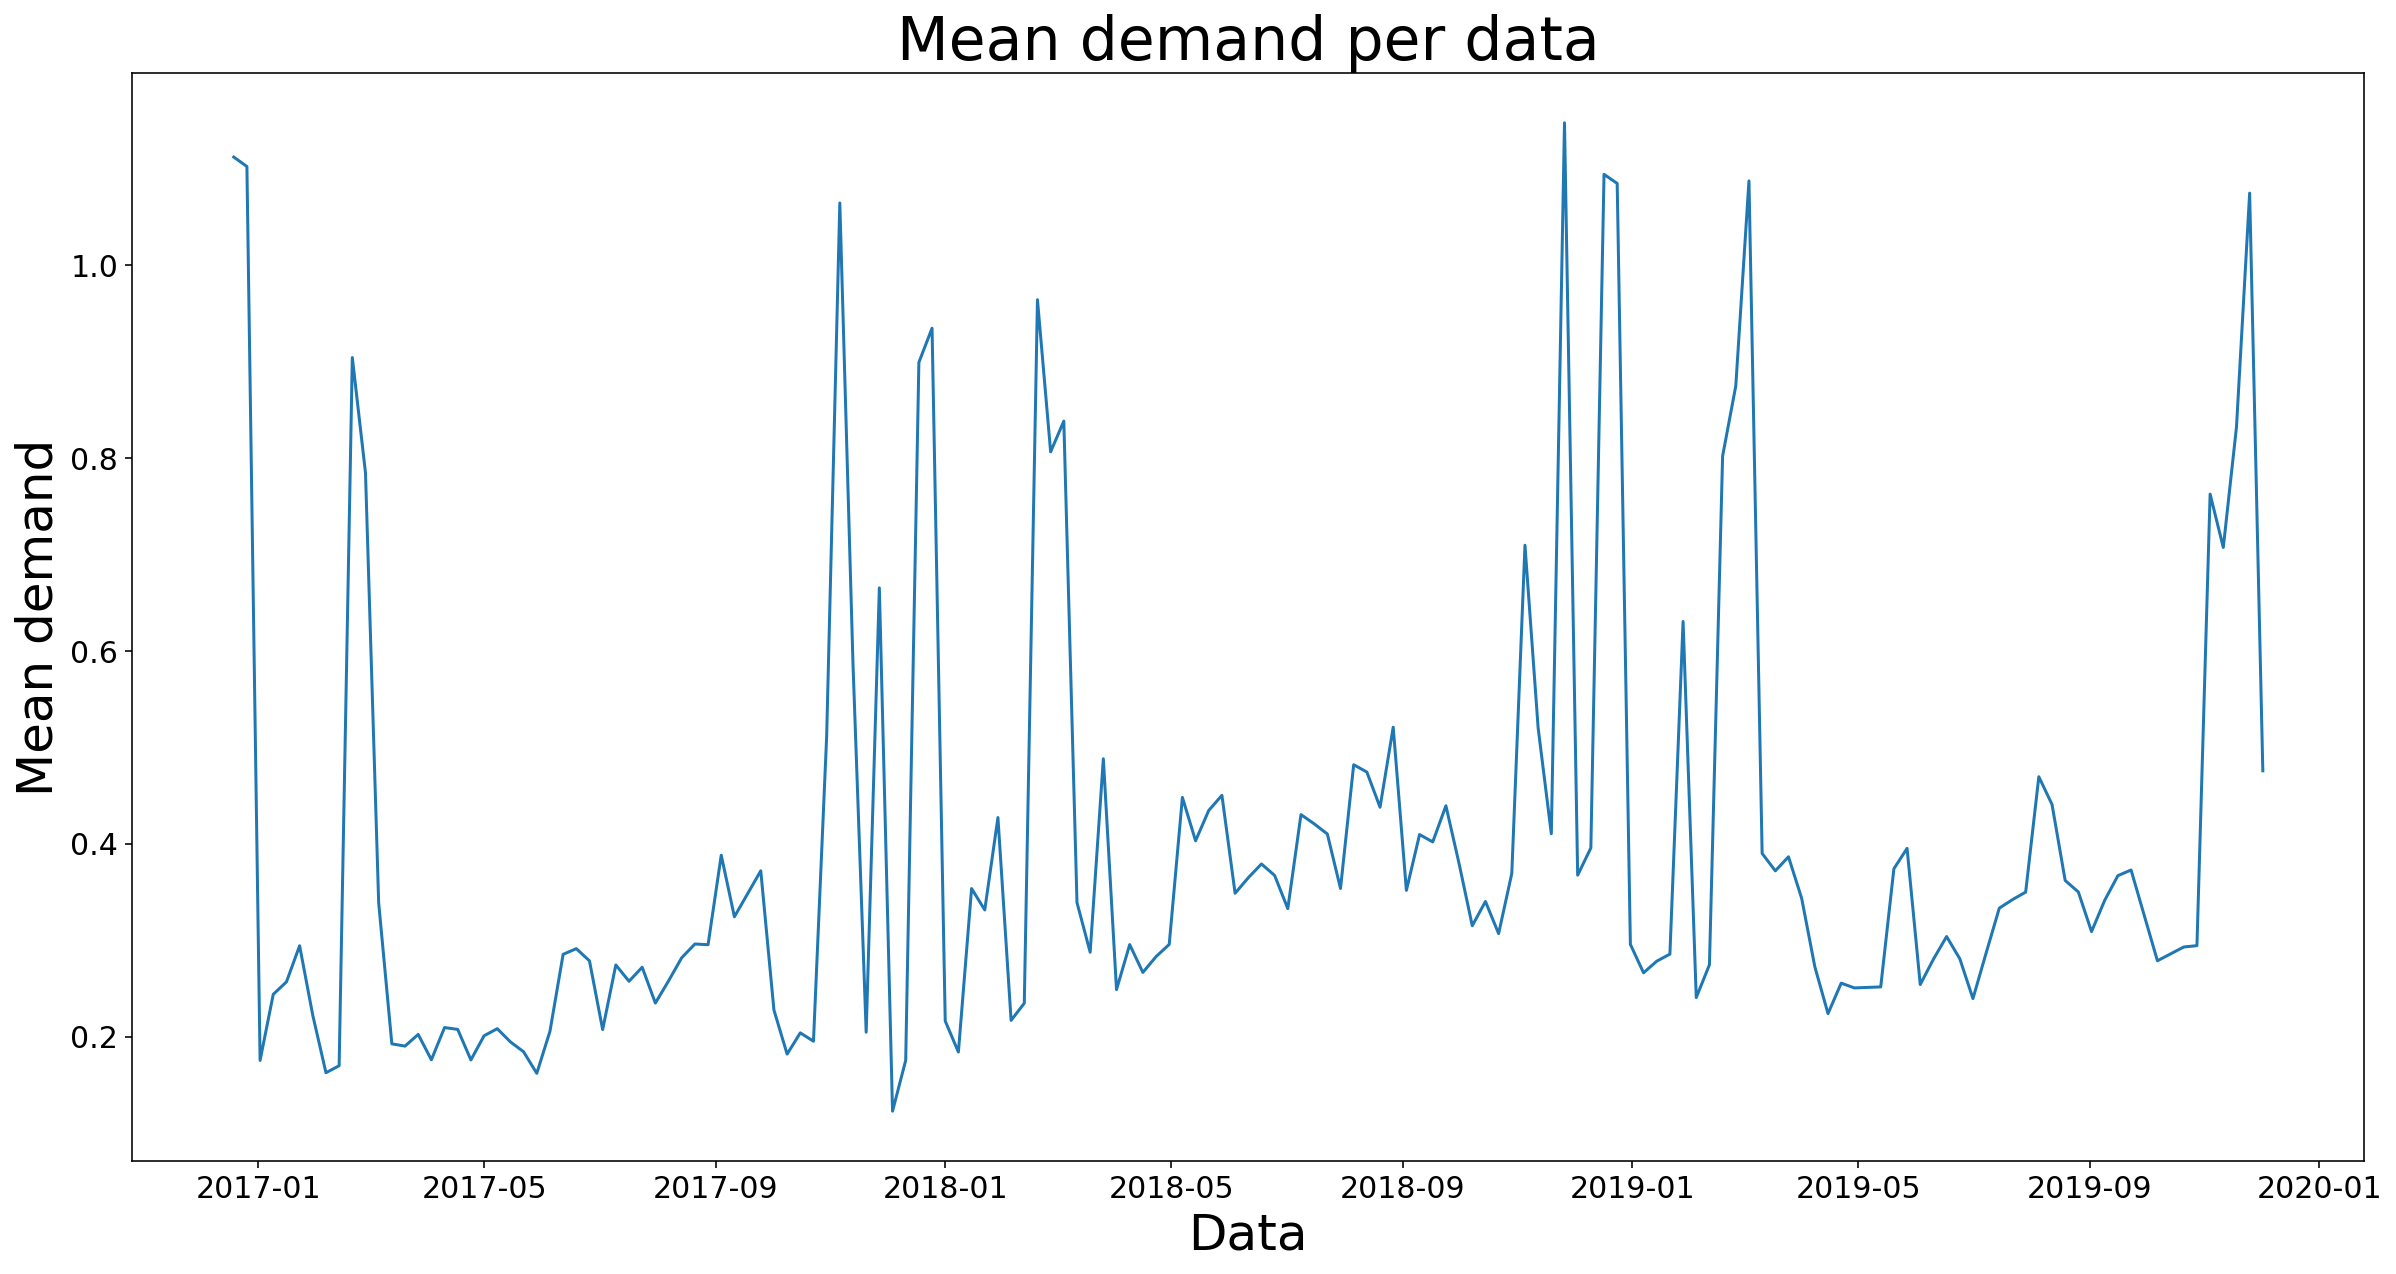

In [5]:
data_grouped_demand = train.groupby(['period_dt'])['demand'].mean().reset_index()
sns.lineplot(data=data_grouped_demand , x='period_dt', y='demand')
plt.xlabel("Data", fontsize = 25)
plt.ylabel("Mean demand", fontsize = 25)
plt.title("Mean demand per data", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [6]:
location_grouped_demand = train.groupby(['location_id'])['demand'].mean().to_dict()
product_grouped_demand = train.groupby(['product_category_1'])['demand'].mean().to_dict()

In [7]:
import numpy as np
train_ = train.copy()
train_['month'] = train_['period_dt'].apply(lambda x: x.month)
train_['year'] = train_['period_dt'].apply(lambda x: x.year)
peaks = data_grouped_demand[data_grouped_demand['demand'] > 1]['period_dt']
train_['peaks'] = np.where(train_['period_dt'].isin(peaks), 1, 0)

train_['location_grouped_demand'] = np.nan
train_['product_grouped_demand'] = np.nan

train_['location_grouped_demand'] = train_['location_id'].apply(lambda x: location_grouped_demand[x])
train_['product_grouped_demand'] = train_['product_category_1'].apply(lambda x: product_grouped_demand[x] if x in product_grouped_demand else np.nan)
train_['product_grouped_demand'] = np.where(train_['product_grouped_demand'].isnull(), train_['location_grouped_demand'], train_['product_grouped_demand'])

X_train = train_[['PROMO1_FLAG', 'PROMO2_FLAG', 'AUTORIZATION_FLAG', 'peaks', 'ACTUAL_PRICE', 
                  'location_grouped_demand', 'product_grouped_demand', 'month', 'year']]
y_train = train_['demand']

In [8]:
test_ = test.copy()
test_['month'] = test_['period_dt'].apply(lambda x: x.month)
test_['year'] = test_['period_dt'].apply(lambda x: x.year)
test_['peaks'] = np.where((test_['period_dt'] == dt.date(2019, 12, 16)) |  (test_['period_dt'] == dt.date(2019, 12, 23)), 1, 0)

test_['location_grouped_demand'] = test_['location_id'].apply(lambda x: location_grouped_demand[x])
test_['product_grouped_demand'] = test_['product_category_1'].apply(lambda x: product_grouped_demand[x] if x in product_grouped_demand else np.nan)
test_['product_grouped_demand'] = np.where(test_['product_grouped_demand'].isnull(), test_['location_grouped_demand'], test_['product_grouped_demand'])

X_test = test_[['PROMO1_FLAG', 'PROMO2_FLAG', 'AUTORIZATION_FLAG', 'peaks', 'ACTUAL_PRICE', 
                  'location_grouped_demand', 'product_grouped_demand', 'month', 'year']]

In [9]:
from catboost import CatBoostRegressor, Pool

categorical = ['month', 'year', 'PROMO1_FLAG', 'PROMO2_FLAG', 'AUTORIZATION_FLAG', 'peaks']

model = CatBoostRegressor(random_state=42, iterations=1000, loss_function='MAE')
pool_train = Pool(X_train, y_train, cat_features=categorical)
pool_test = Pool(X_test, cat_features=categorical)
model.fit(pool_train, verbose=0)
y_pred = model.predict(pool_test)

In [10]:
test_['demand_regression'] = y_pred

In [11]:
'''

from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate':[0.0001, 0.005, 0.001, 0.05, 0.01, 0.05, 0.1, 0.2, 0.3],
    'depth':[2, 3, 4, 5, 6, 7, 8],
    'num_leaves':[2, 4, 8, 16, 32, 64]
}

gs = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)
gs.best_params_
'''

"\n\nfrom sklearn.model_selection import GridSearchCV\n\nparam_grid = {\n    'learning_rate':[0.0001, 0.005, 0.001, 0.05, 0.01, 0.05, 0.1, 0.2, 0.3],\n    'depth':[2, 3, 4, 5, 6, 7, 8],\n    'num_leaves':[2, 4, 8, 16, 32, 64]\n}\n\ngs = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')\ngs.fit(X_train, y_train)\ny_pred = gs.predict(X_test)\ngs.best_params_\n"

### Let's try to make prediction based on 2 models. ###

In [12]:
train_3_weeks = train_[train_['period_dt'] >= (dt.date(2019, 12, 2))-dt.timedelta(days=14)]
train_3_weeks

,period_dt,location_id,product_id,demand,PROMO1_FLAG,PROMO2_FLAG,NUM_CONSULTANT,AUTORIZATION_FLAG,id,ACTUAL_PRICE,location_zone_1,product_category_1,month,year,peaks,location_grouped_demand,product_grouped_demand
265628,2019-11-18,1328,29751,1.000000,1,0,0,1,31260,2099.500000,54,3876,11,2019,0,0.741235,0.296548
265629,2019-11-18,1185,62265,1.000000,1,0,0,1,80914,1924.500000,258,9912,11,2019,0,0.325276,0.383430
265630,2019-11-18,1281,29751,1.000000,1,0,0,1,31259,3599.142857,203,3876,11,2019,0,0.531161,0.296548
265631,2019-11-18,525,29751,2.275862,1,0,0,1,31258,2099.500000,54,3876,11,2019,0,0.299800,0.296548
265632,2019-11-18,1034,93134,0.042017,1,0,0,1,158442,2661.750000,203,3908,11,2019,0,0.380439,0.318278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271928,2019-12-02,1143,88983,0.491237,1,0,0,1,145956,1824.500000,39,9912,12,2019,0,0.275795,0.383430
271929,2019-12-02,1034,88983,0.542515,1,0,0,1,145955,1824.500000,203,9912,12,2019,0,0.380439,0.383430
271930,2019-12-02,798,88983,2.200000,1,0,0,1,145954,1824.500000,203,9912,12,2019,0,0.359709,0.383430
271931,2019-12-02,1380,88983,1.000000,1,0,0,1,145964,2530.260000,219,9912,12,2019,0,0.647002,0.383430


In [13]:
test_['nearest_shops_demand'] = np.nan
test_['nearest_products_demand'] = np.nan
test_

,period_dt,location_id,product_id,demand,PROMO1_FLAG,PROMO2_FLAG,NUM_CONSULTANT,AUTORIZATION_FLAG,id,ACTUAL_PRICE,location_zone_1,product_category_1,month,year,peaks,location_grouped_demand,product_grouped_demand,demand_regression,nearest_shops_demand,nearest_products_demand
0,2019-12-30,1162,22939,NaN,0,0,0,1,16,3649.0,189,3876,12,2019,0,0.328341,0.296548,0.066652,NaN,NaN
1,2019-12-30,1162,23162,NaN,0,0,0,1,7867,3799.0,189,9912,12,2019,0,0.328341,0.383430,0.074552,NaN,NaN
2,2019-12-16,1162,23163,NaN,0,0,0,1,8667,3799.0,189,9912,12,2019,1,0.328341,0.383430,0.847342,NaN,NaN
3,2019-12-23,798,23632,NaN,0,0,0,1,14835,3999.0,203,9912,12,2019,1,0.359709,0.383430,0.854422,NaN,NaN
4,2019-12-30,1347,23633,NaN,0,0,0,1,14959,3999.0,189,9912,12,2019,0,0.555887,0.383430,0.231246,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,2019-12-16,1326,139157,NaN,1,0,0,1,203996,2449.5,203,9912,12,2019,1,0.432244,0.383430,1.062011,NaN,NaN
589,2019-12-09,1347,139157,NaN,0,0,0,0,203997,4899.0,189,9912,12,2019,0,0.555887,0.383430,0.447041,NaN,NaN
590,2019-12-09,425,148040,NaN,0,0,0,1,204035,3549.0,203,3885,12,2019,0,0.298990,1.019251,0.269559,NaN,NaN
591,2019-12-09,525,148040,NaN,0,0,0,1,204037,3549.0,54,3885,12,2019,0,0.299800,1.019251,0.288485,NaN,NaN


In [14]:
for iter, row in test_.iterrows():
    product_locations = train_3_weeks[train_3_weeks['product_id'] == row['product_id']]
    if not product_locations[product_locations['location_zone_1'] == row['location_zone_1']].empty:
        product_locations = product_locations[product_locations['location_zone_1'] == row['location_zone_1']]
    test_.loc[iter, 'nearest_shops_demand'] = product_locations['demand'].mean()

    location_products = train_3_weeks[train_3_weeks['location_id'] == row['location_id']]
    if not location_products[location_products['product_category_1'] == row['product_category_1']].empty:
        location_products = location_products[location_products['product_category_1'] == row['product_category_1']]
    test_.loc[iter, 'nearest_products_demand'] = location_products['demand'].mean()

In [15]:
print(test_['nearest_shops_demand'].isnull().sum())
print(test_['nearest_products_demand'].isnull().sum())

155
0


In [16]:
test_['nearest_shops_demand'] = np.where(test_['nearest_shops_demand'].isnull(), test_['nearest_products_demand'], test_['nearest_shops_demand'])
test_['demand_3_weeks'] = 0.25 * test_['nearest_shops_demand'] + 0.75 * test_['nearest_products_demand']

In [17]:
test_['demand'] = 0.75 * test_['demand_3_weeks'] + 0.25 * test_['demand_regression']

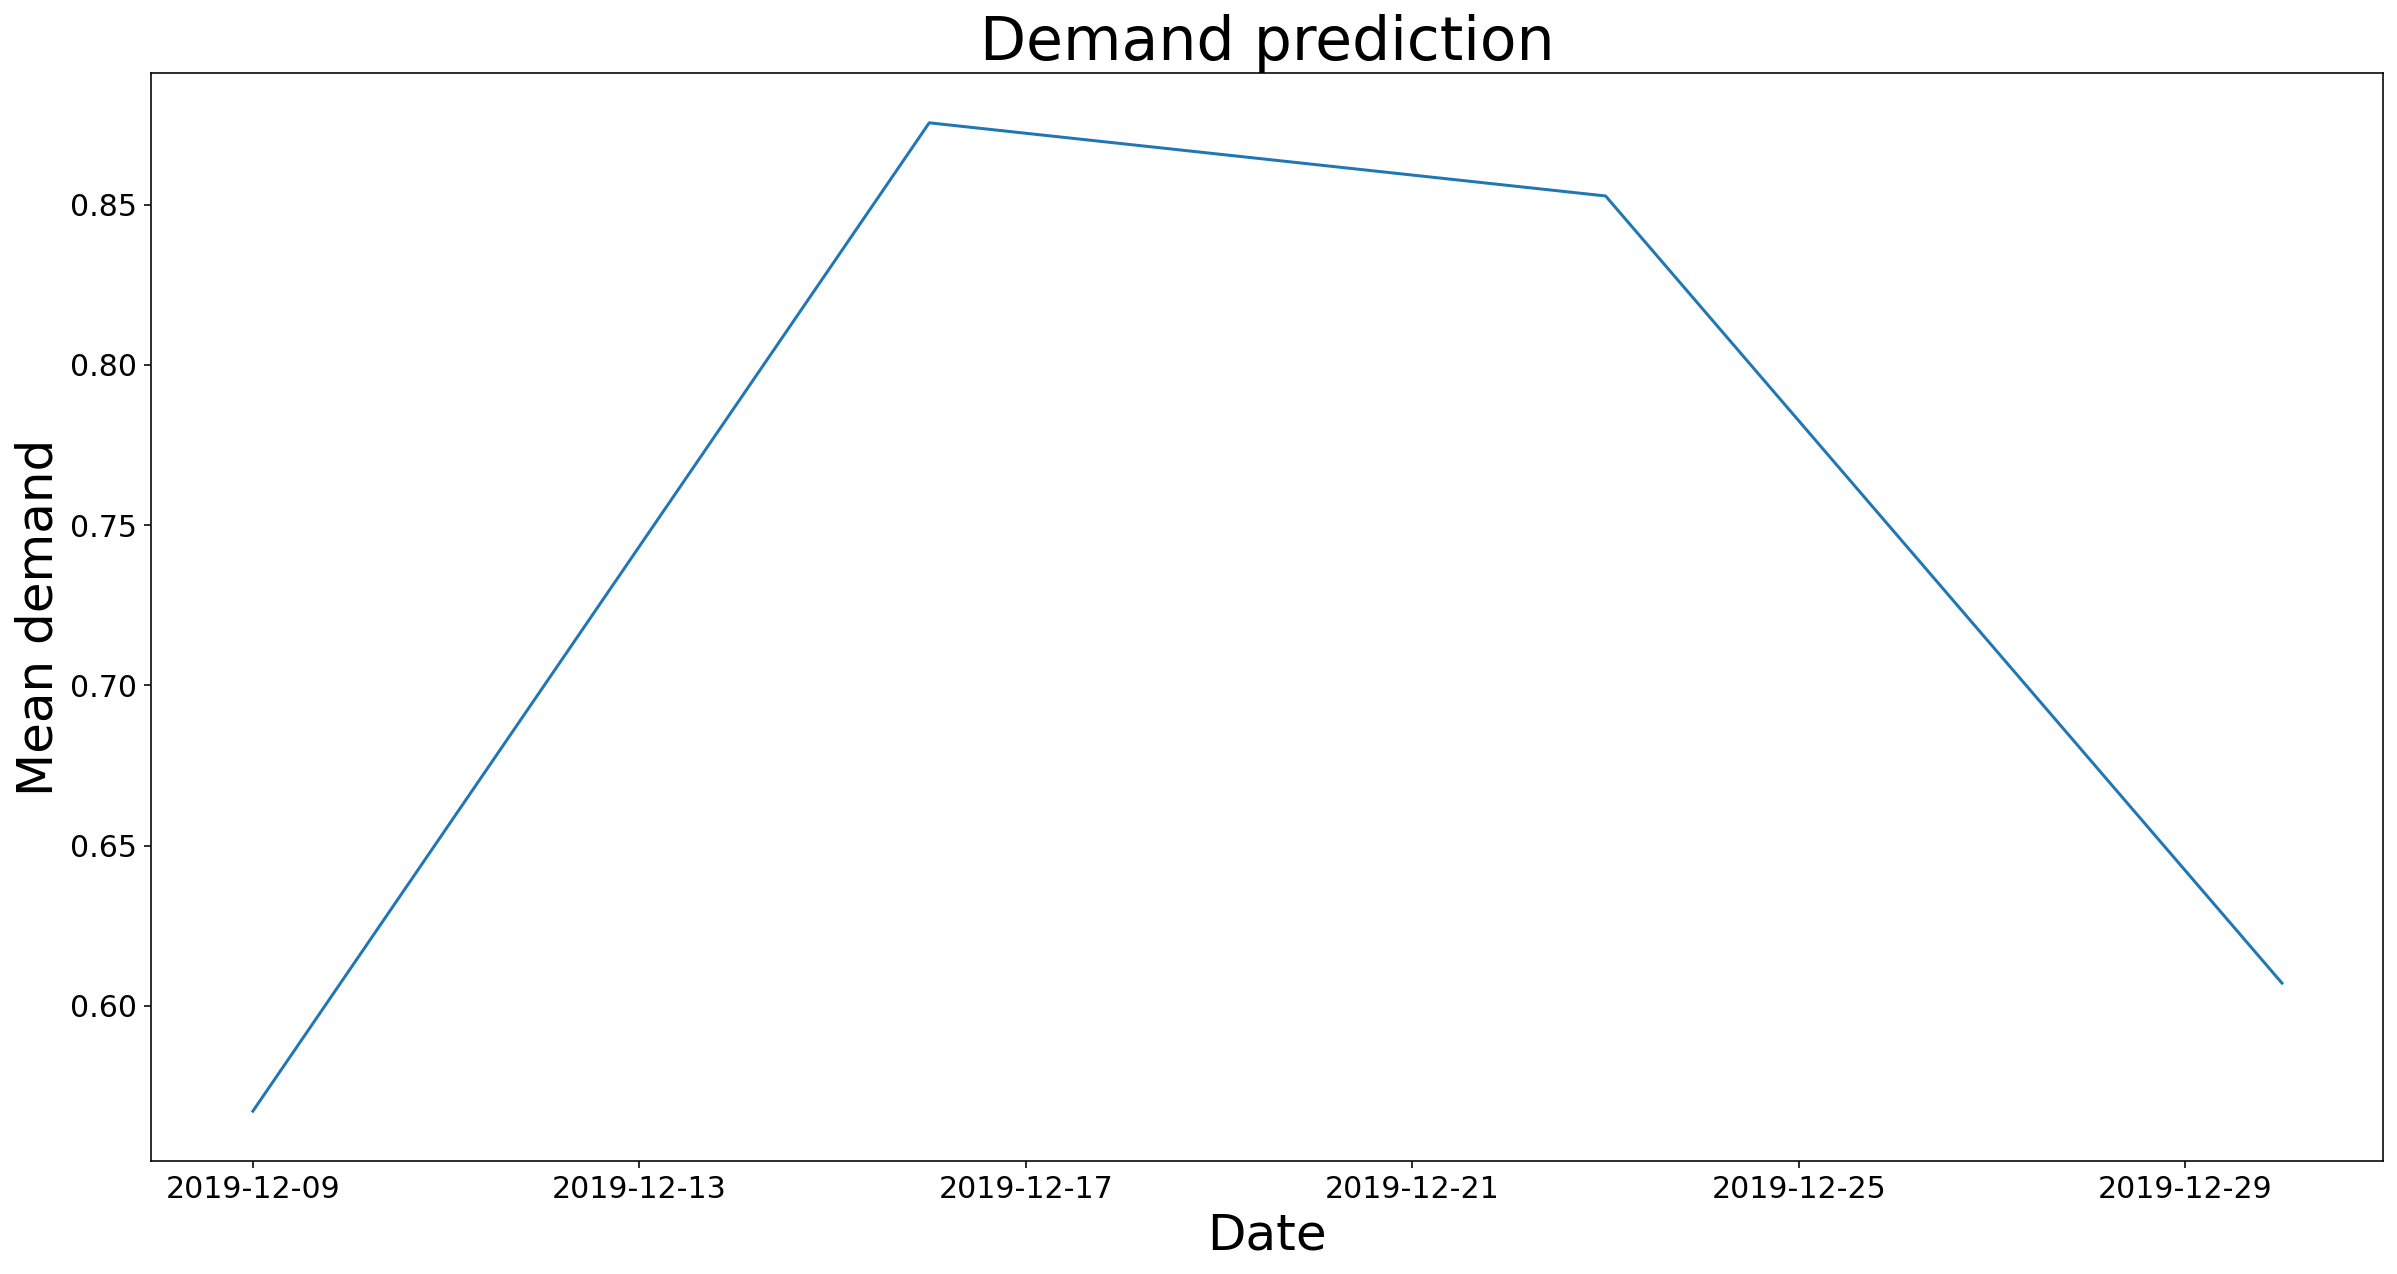

In [18]:
demand_prediction_ = test_.groupby(['period_dt'])['demand'].mean().reset_index()
sns.lineplot(data=demand_prediction_, x='period_dt', y='demand')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Mean demand", fontsize = 25)
plt.title("Demand prediction", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [19]:
test_['demand'] = test_['demand'].apply(lambda x: 0 if x < 0.25 else x)
test_['demand'] = test_['demand'].apply(lambda x: 1 if x >= 0.25 and x <= 1.75 else x)

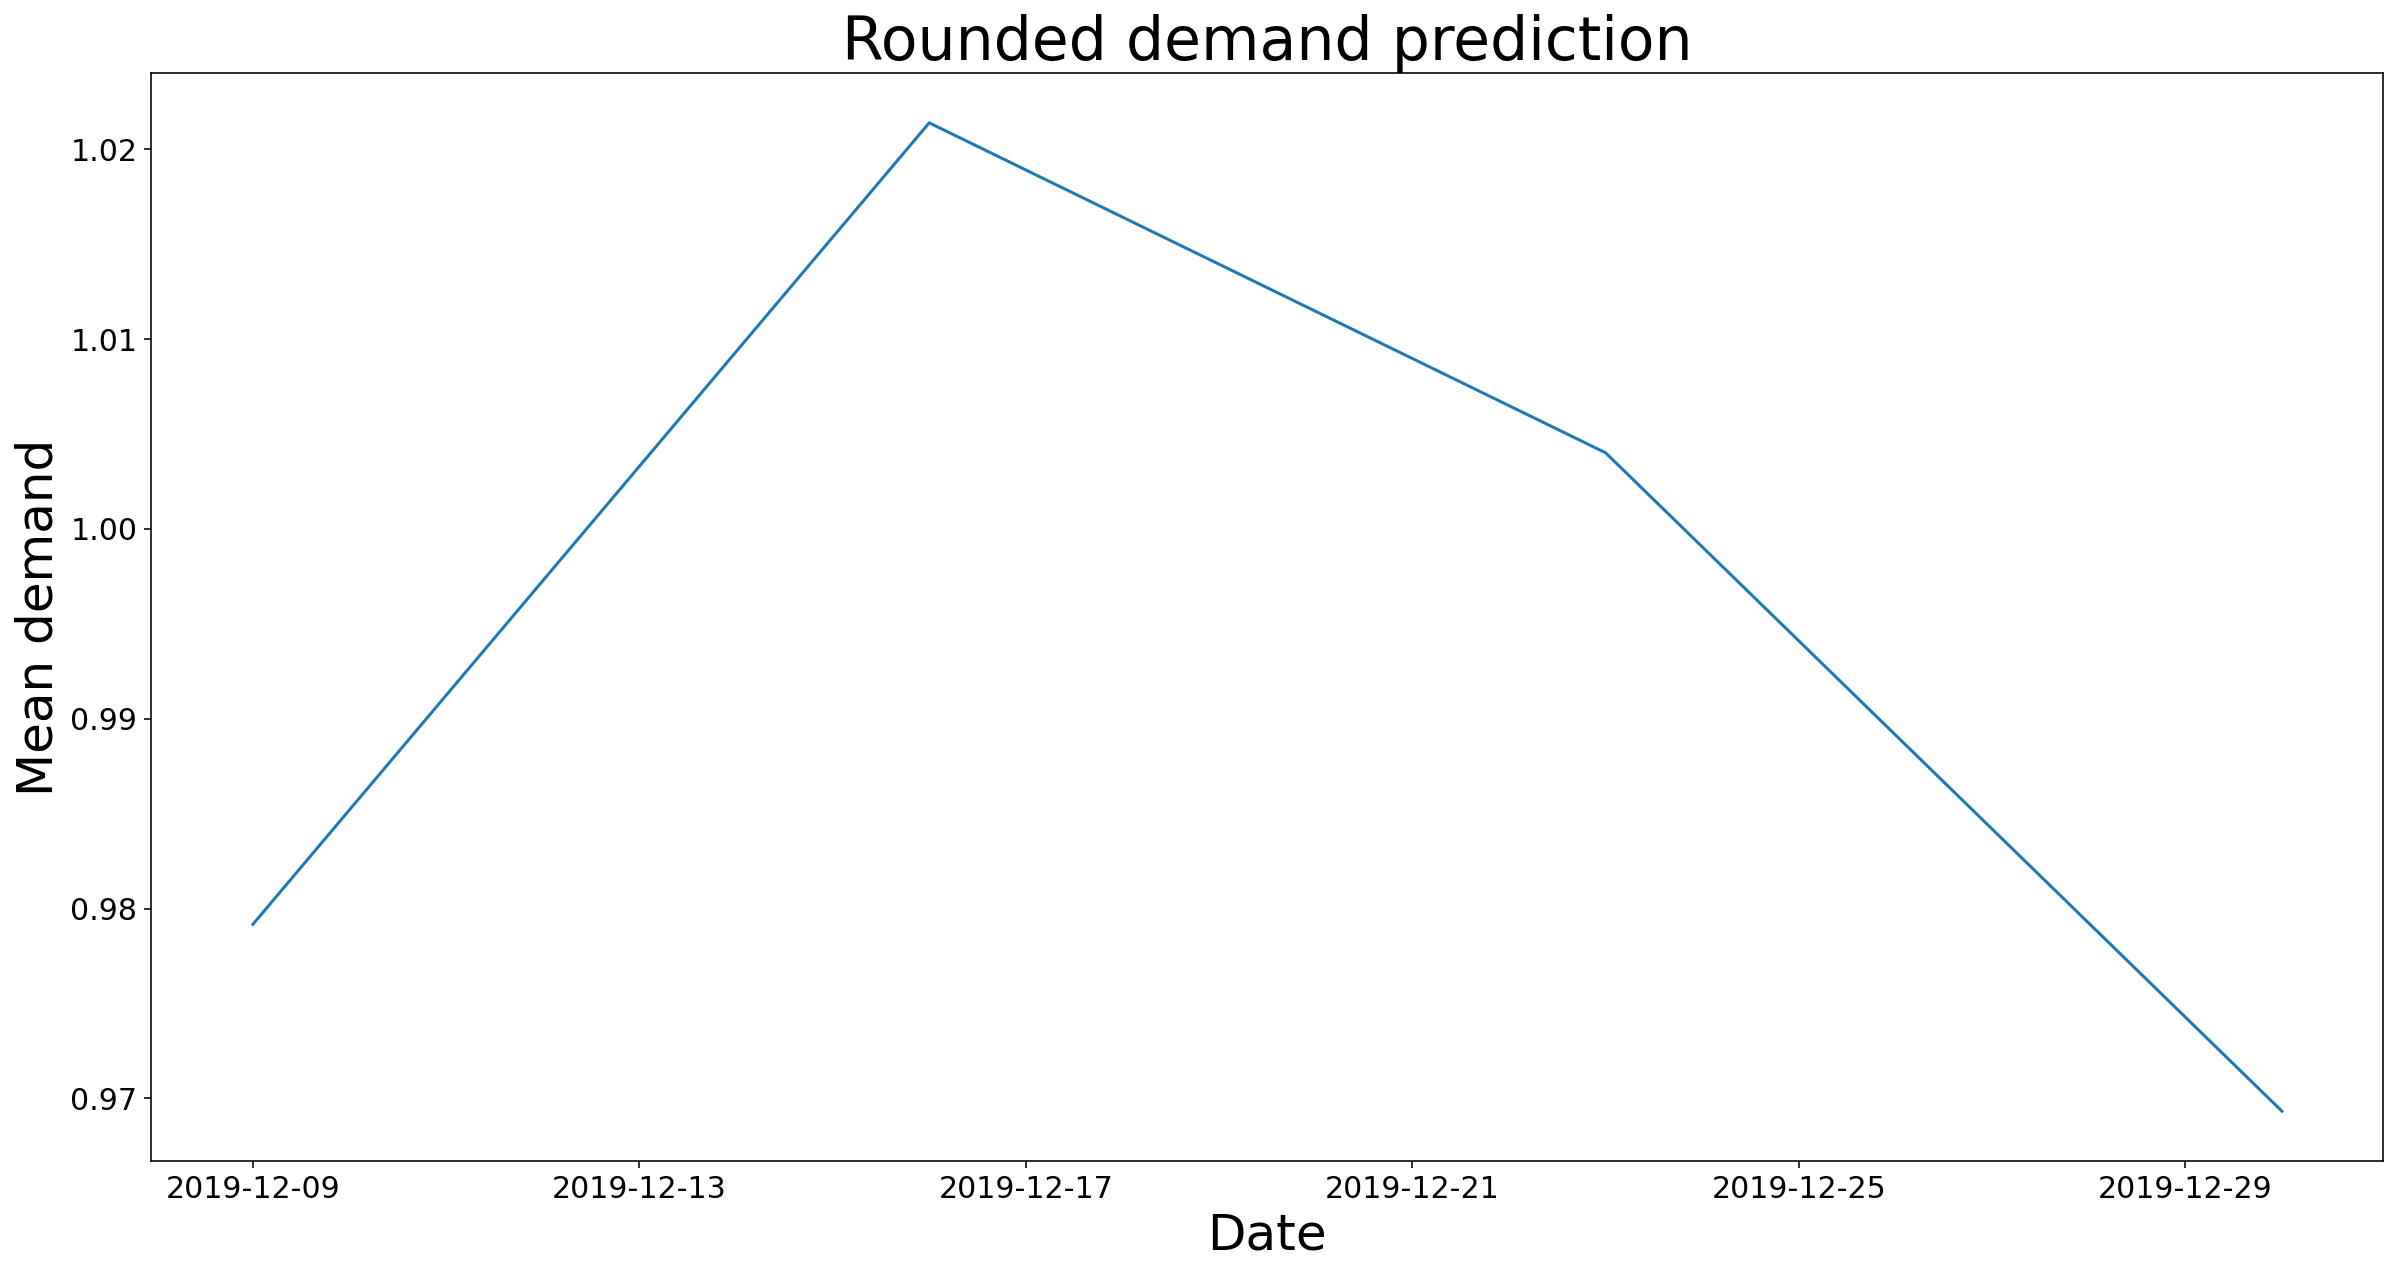

In [20]:
demand_prediction_rounded = test_.groupby(['period_dt'])['demand'].mean().reset_index()
sns.lineplot(data=demand_prediction_rounded, x='period_dt', y='demand')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Mean demand", fontsize = 25)
plt.title("Rounded demand prediction", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [21]:
test_['demand'] = np.where((test_['period_dt'] == dt.date(2019, 12, 16)) | (test_['period_dt'] == dt.date(2019, 12, 23)), np.maximum(1, test_['demand']), test_['demand'])

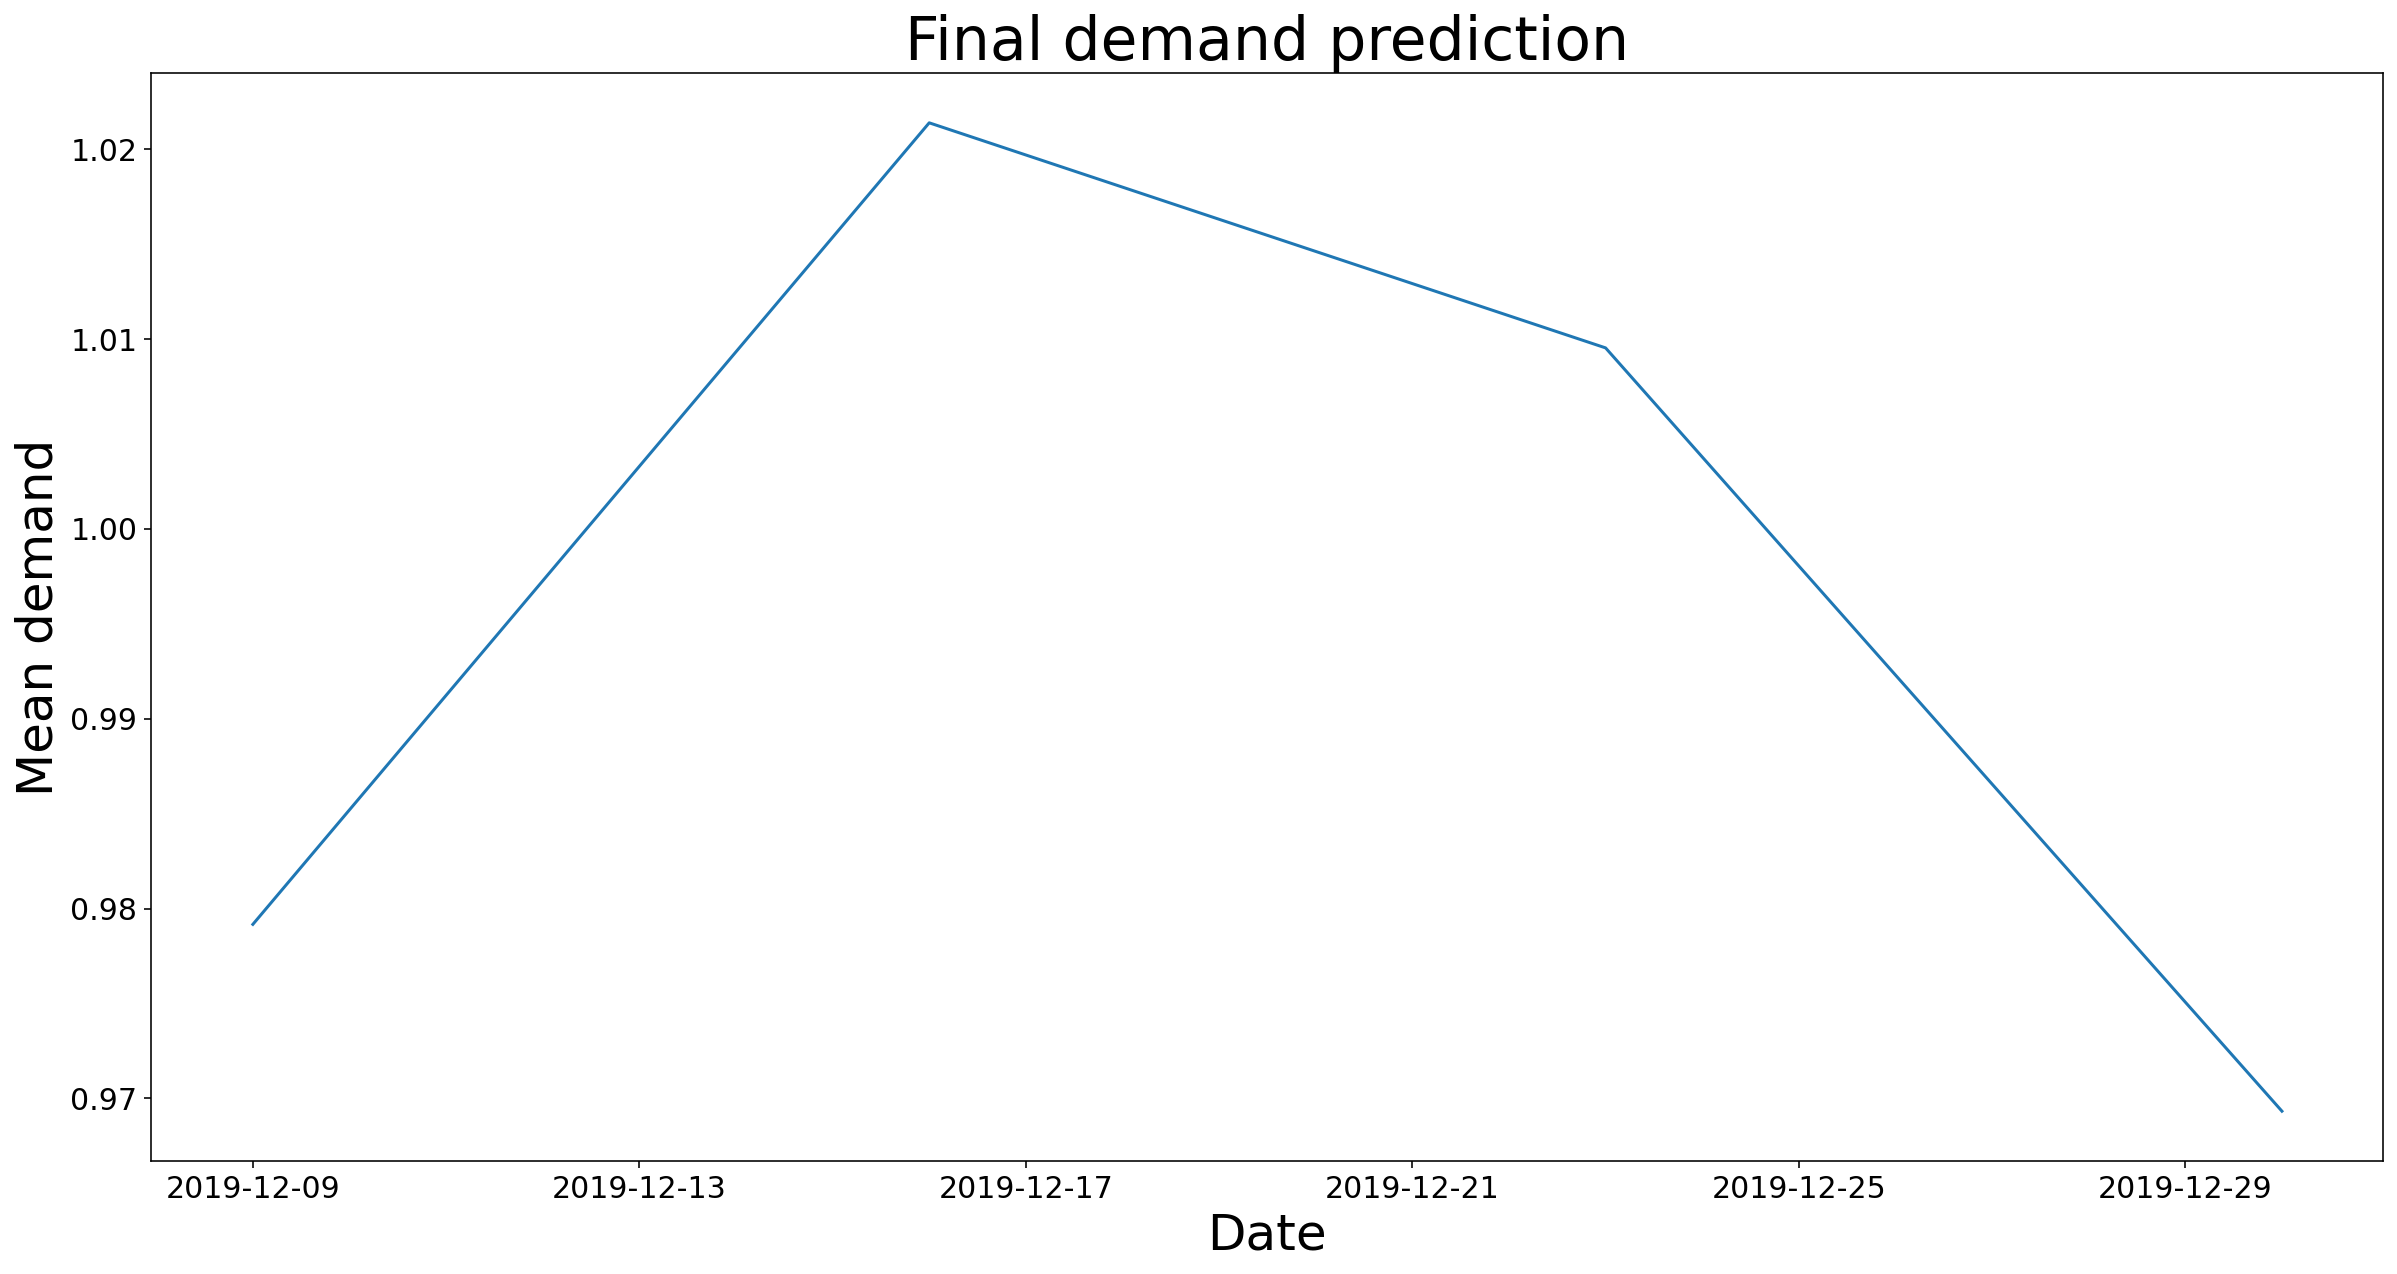

In [22]:
demand_prediction_final = test_.groupby(['period_dt'])['demand'].mean().reset_index()
sns.lineplot(data=demand_prediction_final, x='period_dt', y='demand')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Mean demand", fontsize = 25)
plt.title("Final demand prediction", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [23]:
answer_df = test_[['id', 'demand']]
answer_df.to_csv('out.csv', index=False)